#Подключение библиотек

In [1]:
import os
import time
from datetime import date
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import re
import pandas as pd
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from google.colab import drive, output
drive.mount('/content/gdrive')
drive_data_path = 'gdrive/My Drive/MiMOBOD/'
output.clear()

# Сбор данных

In [2]:
def get_page(url):
  try:
    page = requests.get(url)
    page.raise_for_status()
  except Exception as e:
    print(e)
    return None
  else:
    return page

In [17]:
# берём ссылку на первую страницу предложейний сдачи квартир с браузера и засекаем время исполнения
URL = "https://re.kufar.by/l/minsk/snyat/kvartiru-dolgosrochno?cur=USD"
start_time = time.time()
rent_elements = []
scrab_error = False
# формирует сет со ссылками на описание каждого предложения во избежание повторов
elements_ref_set = set()
# получаем html страницы и находим класс, содержащий количество страниц в предложениях
page = get_page(URL)
if page:
  soup = BeautifulSoup(page.content, "html.parser")
  try:
    n_pages = int(soup.find_all("a", class_="kf-eaFC-63a11")[-2].text)
    print(n_pages)
  except Exception:
    print('Bad number of pages')
    n_pages = '0'
  URL_page = URL

  for i in range(n_pages):
    if scrab_error:
      break
    output.clear()
    print("Page ", i+1, "/", int(n_pages))
    # получаем html страницы с предложениями, на ней находим ссылку на следующую страницу, которая отображается стрелочкой "дальше"
    page = get_page(URL_page)
    if not page:
      scrab_error = True
    soup = BeautifulSoup(page.content, "html.parser")
    try:
      next_page = soup.find_all("a", class_="kf-eaFC-63a11 kf-easz-33922")[-1].get('href')
    except Exception:
      print('Bad next page', i+1)
      break
    URL_page = "https://re.kufar.by" + next_page

    # циклом проходим по каждому элементу на странице
    if not soup.find_all("a", class_="kf-FARC-55673"):
      print('Cannot find elements on page')
      scrab_error = True
      break
    for element in soup.find_all("a", class_="kf-FARC-55673"):

      # получам ссылку на страницу с описанием элемента, проверяем, встречалась ли она раньше
      element_ref=element.get('href')
      if element_ref in elements_ref_set:
        continue
      elements_ref_set.add(element_ref)
      element_page = get_page(element_ref)
      element_soup = BeautifulSoup(element_page.content, "html.parser")
      
      # формируется словарь "название описания" : "значение", для каждого элемента он получатся немного разный
      feats_dict = dict()  
      feats_dict['URL'] = element_ref
      feats_dict['Date'] = date.today().strftime("%d/%m/%Y")
      # практически всё описание предложения содержится в kf-RrYL-321f6
      if not element_soup.find_all("div", class_="kf-RrYL-321f6"):
        print('Cannot find info element')
        scrab_error = True
        break
      for feat in element_soup.find_all("div", class_="kf-RrYL-321f6"):
        value = np.nan
        key = feat.find("div", class_="kf-RrYf-35f08").text
        if feat.find("a", class_="kf-RrYE-854c8"):
          value = feat.find("a", class_="kf-RrYE-854c8").text      
        elif feat.find("div", class_="kf-RrYZ-38305"): 
          value = feat.find("div", class_="kf-RrYZ-38305").text
        if value:
          feats_dict[key] = value      

      # добавляем дополнительное описание из других классов-элементов страницы
      if element_soup.find("div", class_="kf-HHCF-ae1ac"):
        feats_dict["Описание"] = element_soup.find("div", class_="kf-HHCF-ae1ac").text
      else:
        print('Cannot find description')
        scrab_error = True
        break
      if element_soup.find("span", class_="kf-RtPp-f9db0"):
        feats_dict["Цена $"] = element_soup.find("span", class_="kf-RtPp-f9db0").text
      elif element_soup.find("span", class_="kf-Rtx-d260c"):
        continue
      else:
        print('Cannot find cost')
        scrab_error = True
        break
      if element_soup.find("span", class_="kf-PJXK-96099"):
        feats_dict["Количество фото"] = element_soup.find("span", class_="kf-PJXK-96099").text  
      elif element_soup.find("div", class_="kf-PJXk-8e17c"):
        feats_dict["Количество фото"] = "нет"
      else:
        print('Cannot find photo')
        scrab_error = True
        break

      rent_elements.append(feats_dict)  

if scrab_error:
  print('Something wrong')
print("Elements:", len(rent_elements))
time_delta = time.time() - start_time
if rent_elements:
  print(time_delta//60, "m", round(time_delta % 60), "s ----", round(time_delta/len(rent_elements), 1), "s per element")


Page  52 / 52
Elements: 1498
35.0 m 19 s ---- 1.4 s per element


In [18]:
new_df = pd.DataFrame(rent_elements)
try:
  old_df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)
except Exception:
  print("File doesn't exist")
  concat_df = new_df
else:
  concat_df = pd.concat([new_df, old_df[~old_df['URL'].isin(new_df['URL'])].dropna(how='all')]).reset_index(drop=True)
concat_df.to_csv(drive_data_path+'Rent_raw.csv')

File doesn't exist


# Очистка данных

In [2]:
df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)
df.head()

,URL,Date,Город / Район,Метро,Количество комнат,Тип аренды,Количество спальных мест,Общая площадь,Жилая площадь,Площадь кухни,Санузел,Ремонт,Обустройство быта,В ванной,На кухне,Кому сдается,Предоплата,Этаж,Этажность дома,Материал стен,Год постройки,Окна выходят,Обустройство дома,В новостройке,Состояние,Описание,Цена $,Количество фото,Балкон,Номер и дата договора,Микрорайон,Возможна рассрочка,Есть проходная комната,Студия,Без мебели,Возможен обмен,Рассрочка от продавца,Пешком до ближайшей станции,До ближайшей станции на транспорте
0,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,24/11/2021,Первомайский,Восток,2,Долгосрочная,4,48 м²,35 м²,12 м²,Совмещенный,Дизайнерский,"Утюг, Мебель, Телевизор, Wi-Fi","Стиральная машина, Душевая кабина","Посуда/столовые приборы, Посудомоечная машина,...",Парам,Месяц,12,25,Каркасно-блочный,2019,"На речку, В парк","Лифт, Мусоропровод, Огороженная территория, До...",Да,Новое,Сдаётся новая стильная квартира на длительный...,700 $ *,8 фото,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,24/11/2021,Октябрьский,Институт культуры,4,Долгосрочная,7,77 м²,60 м²,7.12 м²,Раздельный,Евро,"Wi-Fi, Телевизор, Мебель",Стиральная машина,"Холодильник, СВЧ-печь, Посудомоечная машина, Г...","С детьми, Парам",Залог,4,9,Блочный,1985,"Во двор, На улицу","Лифт, Стояночное место, Домофон",NaN,Вторичное жилье,"4-ех комнатная квартира на улице Могилевская, ...",800 $ *,9 фото,Два,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,24/11/2021,Первомайский,Восток,3,Долгосрочная,NaN,59.6 м²,47 м²,NaN,Совмещенный,NaN,NaN,NaN,NaN,NaN,NaN,25,25,Каркасно-блочный,2017,NaN,NaN,NaN,Новое,Шикарная 3-ёх комнатная квартира в ЖК Маяк-Мин...,1 300 $ *,15 фото,Лоджия,770/2а от 23.11.2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,24/11/2021,Советский,Площадь Якуба Коласа,2,Долгосрочная,NaN,NaN,NaN,NaN,Раздельный,Евро,"Wi-Fi, Телевизор, Мебель",Стиральная машина,"Холодильник, СВЧ-печь, Газовая плита",NaN,NaN,NaN,NaN,Кирпичный,NaN,NaN,NaN,NaN,Вторичное жилье,Квартира в центре города в сталинке с отличным...,450 $ *,14 фото,Есть,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://re.kufar.by/vi/minsk/snyat/kvartiru-do...,24/11/2021,Московский,Площадь Ленина,2,Долгосрочная,NaN,53.3 м²,30 м²,8.7 м²,Раздельный,NaN,"Телефон, Мебель, Телевизор, Wi-Fi",Стиральная машина,"Электрическая плита, СВЧ-печь, Холодильник",NaN,NaN,4,5,NaN,1952,NaN,NaN,NaN,Вторичное жилье,Сдаётся двухкомнатная квартира в самом центре ...,450 $ *,11 фото,Есть,401/2а от 19.08.2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
missing_val = pd.DataFrame(df.isnull().sum())
missing_val = missing_val.reset_index()
missing_val.columns = ['Feature', '% nans']
missing_val['Dtype'] = df.dtypes.values
missing_val['% nans'] = round(missing_val['% nans']*100/len(df), 1)
print(df.duplicated().value_counts(normalize=True))
missing_val.sort_values('% nans', ascending=False)

False    1.0
dtype: float64


,Feature,% nans,Dtype
38,До ближайшей станции на транспорте,99.9,object
37,Пешком до ближайшей станции,99.9,object
36,Рассрочка от продавца,98.8,object
31,Возможна рассрочка,96.7,object
35,Возможен обмен,95.1,object
34,Без мебели,93.3,object
33,Студия,90.2,object
23,В новостройке,88.0,object
32,Есть проходная комната,87.1,object
15,Кому сдается,69.0,object


In [4]:
def get_number(s):
  n = re.findall(r'\d+', str(s).replace(" ", ""))
  if n:
    return int(n[0])
  else:
    return np.nan

In [35]:
df = pd.read_csv(drive_data_path+'Rent_raw.csv', index_col=0)

df["Цена $"] = df["Цена $"].apply(get_number)
df = df[df["Цена $"]<5000]
df.dropna(subset=['Город / Район'], inplace=True)
df["Общая площадь"] = df["Общая площадь"].apply(get_number)
#df["Жилая площадь"] = df["Жилая площадь"].apply(get_number)
#df["Площадь кухни"] = df["Площадь кухни"].apply(get_number)
df['Агенство'] = df['Номер и дата договора'].apply(lambda x: 1 if not pd.isnull(x) else 0)
df["Количество комнат"] = df["Количество комнат"].apply(get_number)
df["Количество фото"] = df["Количество фото"].apply(get_number)
df["Количество фото"].fillna(0, inplace=True)
df.loc[df["Количество фото"] > 20, 'Количество фото'] = 21
df["Этажность дома"] = pd.to_numeric(df["Этажность дома"], errors='coerce', downcast="integer")
df["Этаж"] = pd.to_numeric(df["Этаж"], errors='coerce', downcast="integer")
df["Возраст дома"] = 2021 - pd.to_numeric(df["Год постройки"], errors='coerce')
df["В новостройке"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
df.loc[df["Возраст дома"]<10, "В новостройке"] = 1
df["Без мебели"].replace({"Да": 1, "-": 0, np.nan: 0}, inplace=True)
df["Состояние"].replace({"Вторичное жилье": 0, "Новое": 1, np.nan: 0}, inplace=True)
df["Ремонт"].replace({'Строительная отделка': 'Без отделки'}, inplace=True)
df.loc[df["Студия"] == "Да", 'Количество комнат'] = 0
df["Санузел"].replace({np.nan:"Раздельный"}, inplace=True)
df["Балкон"].replace({"Лоджия": 1, "Да": 1, "Есть": 1, 'Один':1, "Два":2, 'Нет':0, np.nan: 0}, inplace=True)
df["Предоплата"].replace({"Месяц": 1, "2 месяца": 2, "3 месяца": 3, "Полгода": 6, 
                          "Залог": 1, "Нет": 0,  np.nan: 0}, inplace=True)

cat_columns = ['Ремонт', 'Санузел', 'Город / Район', 'Микрорайон', 'Метро']
df = df[['Город / Район', 'Метро', 'Количество комнат',
         'Общая площадь', 'Санузел', 'Ремонт', 'Обустройство быта', 'В ванной',
         'На кухне', 'Предоплата', 'Этаж', 'Этажность дома', 'Обустройство дома',
         'В новостройке', 'Состояние', 'Цена $', 'Количество фото',
         'Балкон', 'Микрорайон', 'Без мебели', 'Агенство']]

df.head()

,Город / Район,Метро,Количество комнат,Общая площадь,Санузел,Ремонт,Обустройство быта,В ванной,На кухне,Предоплата,Этаж,Этажность дома,Обустройство дома,В новостройке,Состояние,Цена $,Количество фото,Балкон,Микрорайон,Без мебели,Агенство
0,Первомайский,Восток,2,48.0,Совмещенный,Дизайнерский,"Утюг, Мебель, Телевизор, Wi-Fi","Стиральная машина, Душевая кабина","Посуда/столовые приборы, Посудомоечная машина,...",1,12.0,25.0,"Лифт, Мусоропровод, Огороженная территория, До...",1,1,700,8.0,0,NaN,0,0
1,Октябрьский,Институт культуры,4,77.0,Раздельный,Евро,"Wi-Fi, Телевизор, Мебель",Стиральная машина,"Холодильник, СВЧ-печь, Посудомоечная машина, Г...",1,4.0,9.0,"Лифт, Стояночное место, Домофон",0,0,800,9.0,2,NaN,0,0
2,Первомайский,Восток,3,59.0,Совмещенный,NaN,NaN,NaN,NaN,0,25.0,25.0,NaN,1,1,1300,15.0,1,NaN,0,1
3,Советский,Площадь Якуба Коласа,2,NaN,Раздельный,Евро,"Wi-Fi, Телевизор, Мебель",Стиральная машина,"Холодильник, СВЧ-печь, Газовая плита",0,NaN,NaN,NaN,0,0,450,14.0,1,NaN,0,0
4,Московский,Площадь Ленина,2,53.0,Раздельный,NaN,"Телефон, Мебель, Телевизор, Wi-Fi",Стиральная машина,"Электрическая плита, СВЧ-печь, Холодильник",0,4.0,5.0,NaN,0,0,450,11.0,1,NaN,0,1


In [36]:
print(df["Обустройство быта"].str.split(", ").explode().unique())
print(df["На кухне"].str.split(", ").explode().unique())
print(df["В ванной"].str.split(", ").explode().unique())
print(df["Обустройство дома"].str.split(", ").explode().unique())

['Утюг' 'Мебель' 'Телевизор' 'Wi-Fi' nan 'Телефон' 'Кондиционер']
['Посуда/столовые приборы' 'Посудомоечная машина' 'Холодильник' 'СВЧ-печь'
 'Газовая плита' nan 'Электрическая плита' 'Кофеварка']
['Стиральная машина' 'Душевая кабина' nan 'Комплект полотенец' 'Джакузи'
 'Фен']
['Лифт' 'Мусоропровод' 'Огороженная территория' 'Домофон'
 'Видеонаблюдение' 'Стояночное место' nan 'Парковка крытая' 'Пандус'
 'Подвал']


In [37]:
old_columns = set(df.columns)
df = df.join(pd.get_dummies(df["Обустройство быта"].str.split(", ").explode()).sum(level=0)[['Телевизор', 'Кондиционер']])
df = df.join(pd.get_dummies(df["На кухне"].str.split(", ").explode()).sum(level=0)[['СВЧ-печь', 'Холодильник', 'Посудомоечная машина']])
df = df.join(pd.get_dummies(df["В ванной"].str.split(", ").explode()).sum(level=0)[['Стиральная машина', 'Душевая кабина']])
df = df.join(pd.get_dummies(df["Обустройство дома"].str.split(", ").explode()).sum(level=0)[['Огороженная территория', 'Парковка крытая']])
equipment_columns = set(df.columns) - old_columns
equipment_columns.add("Без мебели")
df.drop(columns=["Обустройство быта", "На кухне", "В ванной", "Обустройство дома"], inplace=True)

#Анализ данных

23 квартиры стоимостью выше 1600$ ( 1.5 %
1496 квартир всего


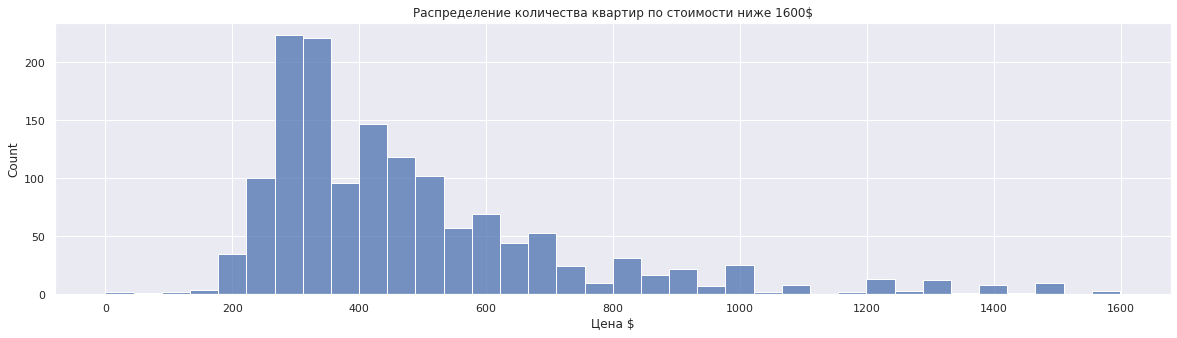

In [27]:
print(len(df[df['Цена $']>=1600]), "квартиры стоимостью выше 1600$ (", round(len(df[df['Цена $']>=1600])/len(df)*100, 1) , "%")
print(len(df), "квартир всего")
sns.set(rc={'figure.figsize':(20,5)})
plt.title("Распределение количества квартир по стоимости ниже 1600$")
sns.histplot(df[df['Цена $']<1600], x='Цена $')
plt.show()

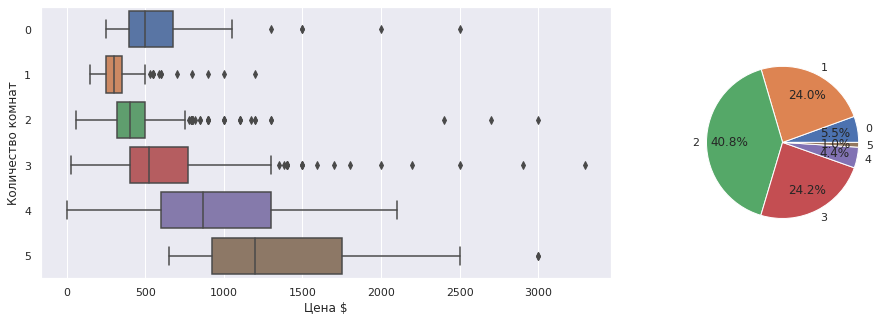

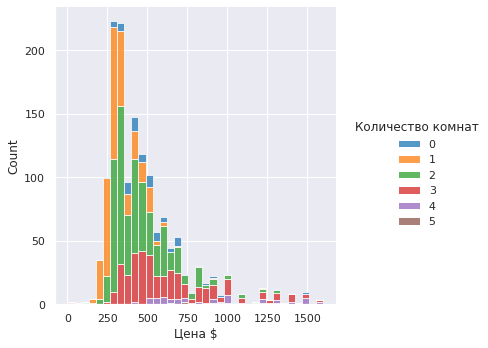

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 1]})
sns.boxplot(data=df, y="Количество комнат", x='Цена $', orient='h', ax=ax1)
s = df["Количество комнат"].value_counts(sort=False).sort_index()
pct = '%1.1f%%'
ax2.pie(s.values, labels=s.index, autopct=pct, pctdistance=0.7) 
plt.show()
# fig, ax = plt.subplots(figsize=(15, 5))
sns.set(rc={'figure.figsize':(20,5)})
sns.displot(data=df[df['Цена $']<1600], x="Цена $", hue="Количество комнат", multiple="stack", palette="tab10")
plt.show()

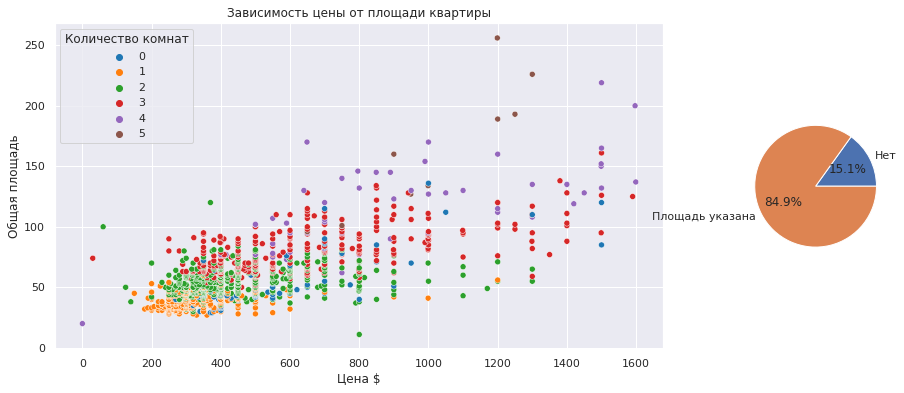

In [23]:
sorted_df = df.sort_values('Общая площадь')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [4, 1]})
ax1.set_title("Зависимость цены от площади квартиры")
sns.scatterplot(data=sorted_df[sorted_df['Цена $']<1600], x="Цена $", y="Общая площадь", hue="Количество комнат", ax=ax1, palette="tab10")
ax2.pie([df['Общая площадь'].isna().sum(), df['Общая площадь'].count()], labels=['Нет', 'Площадь указана'], autopct='%1.1f%%') 
plt.show()

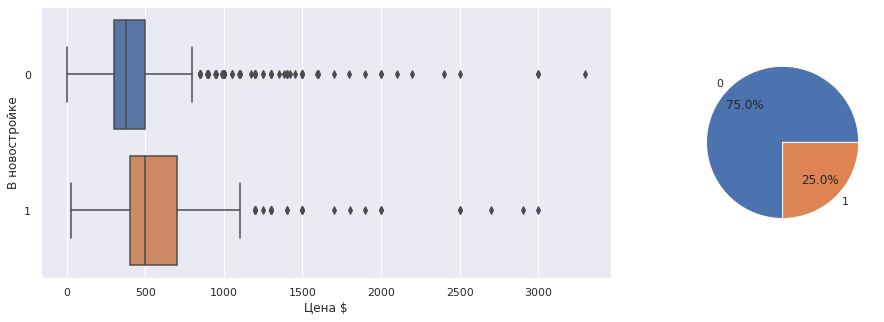

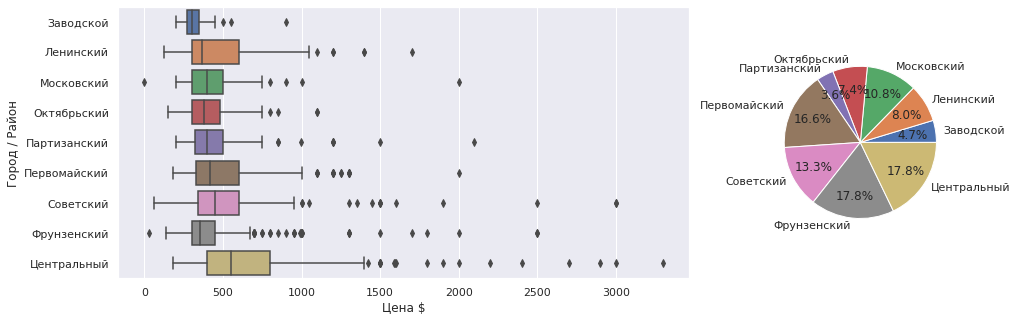

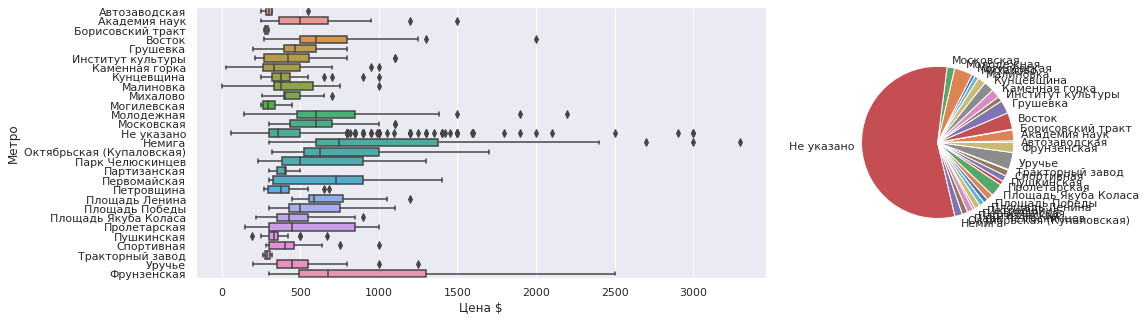

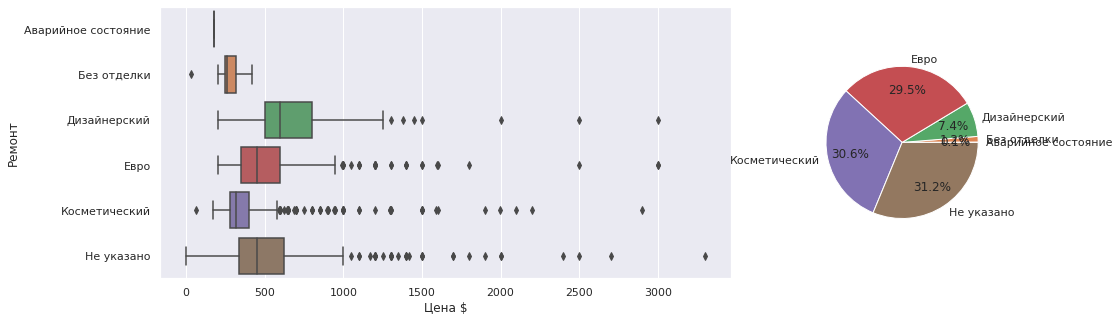

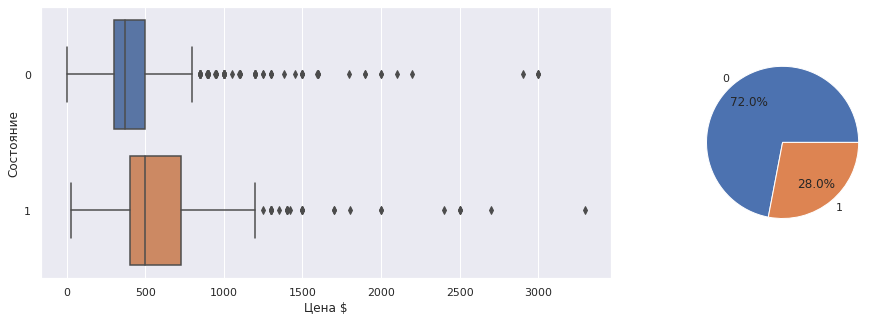

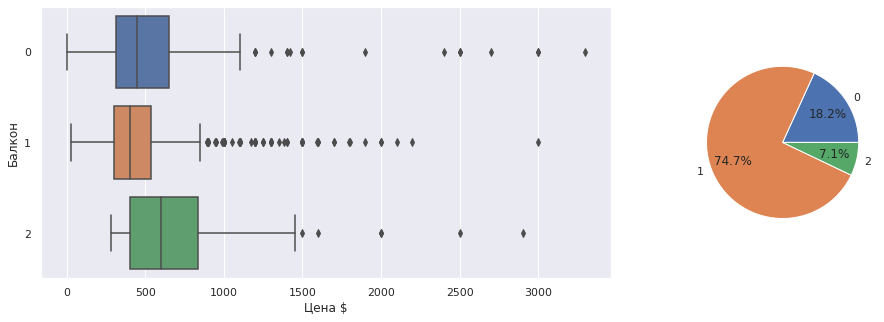

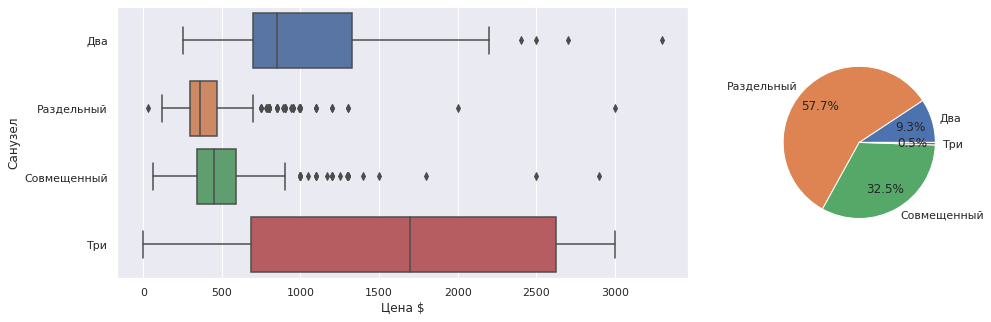

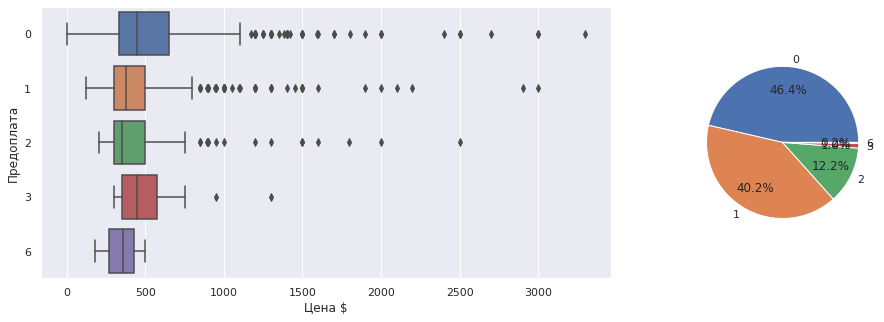

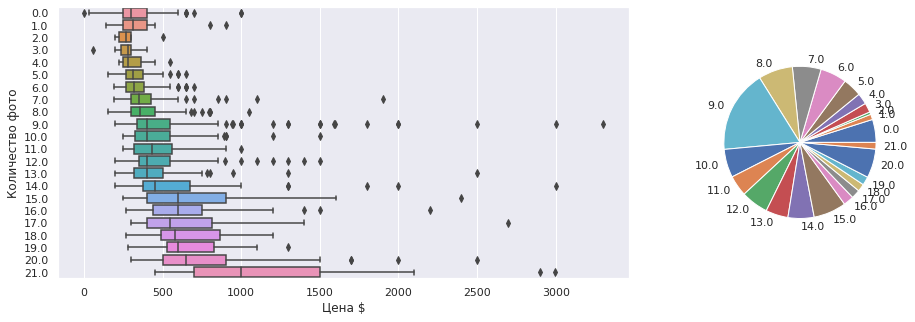

In [24]:
feats = ['В новостройке', 'Город / Район', 'Метро','Ремонт', 'Состояние', 'Балкон', 'Санузел', 'Предоплата', 'Количество фото']
df_fill = df.fillna("Не указано")
for feat in feats:
  sorted_df = df_fill.sort_values(feat)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [3, 1]})
  sns.boxplot(data=sorted_df, y=feat, x='Цена $', orient='h', ax=ax1)
  pct = None if feat in ['Количество фото', 'Метро'] else '%1.1f%%' 
  s = sorted_df[feat].value_counts(sort=False).sort_index()
  ax2.pie(s.values, labels=s.index, autopct=pct, pctdistance=0.7) 
  plt.show()

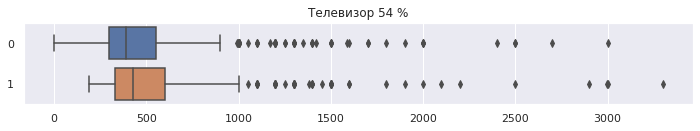

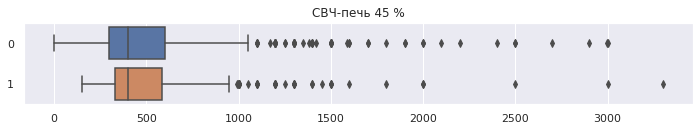

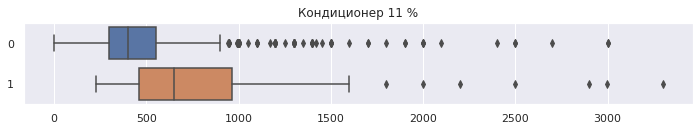

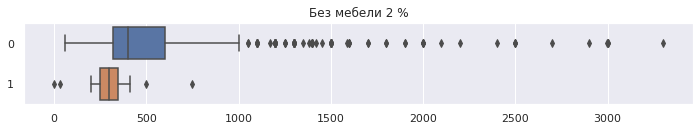

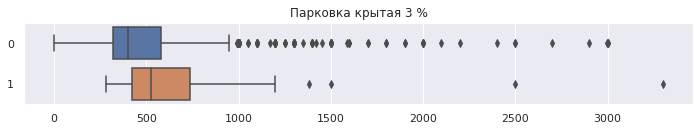

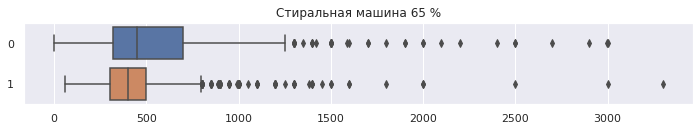

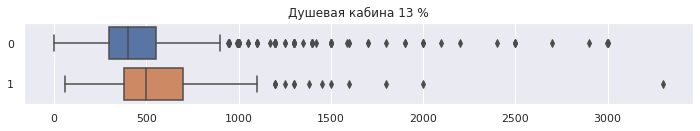

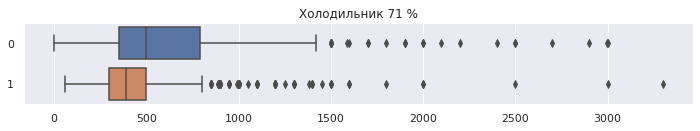

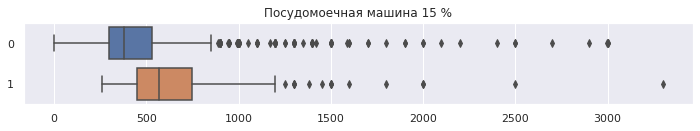

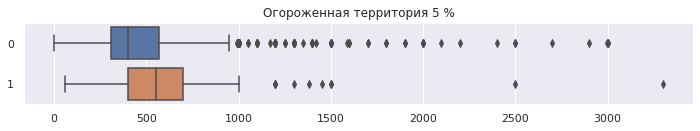

In [25]:
for feat in equipment_columns:
  fig, ax = plt.subplots(1, 1, figsize = (12, 1.5))
  sns.boxplot(data=df, x='Цена $', y=feat, orient='h') 
  ax.set_ylabel('')    
  ax.set_xlabel('')
  ax.set_title(feat + ' ' + str(round(100*sum(df[feat]==1)/len(df))) + ' %')
  plt.show()

#Предсказание

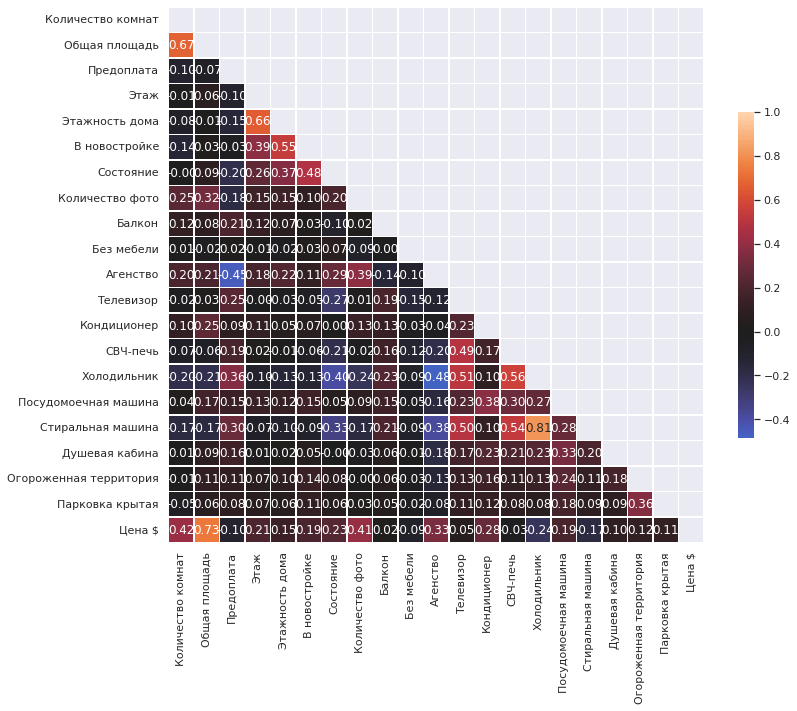

In [26]:
cols = list(df.drop(columns=['Цена $']).columns)
cols.append('Цена $')
corr_matrix = df[cols].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate

dum_df = df.join(pd.get_dummies(df[cat_columns], dummy_na=True, drop_first=True)).drop(columns=cat_columns)
dum_df = dum_df[dum_df['Цена $']<1500]
dum_df["Общая площадь"] = dum_df.groupby("Количество комнат").transform(lambda x: x.fillna(x.mean()))
dum_df['Этаж'].fillna(dum_df['Этаж'].mean(), inplace=True)
dum_df['Этажность дома'].fillna(dum_df['Этажность дома'].mean(), inplace=True)
y = dum_df['Цена $']
X = dum_df.drop(columns=['Цена $'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# def get_error(test, pred):
#    return {'mae': round(mean_absolute_error(test, pred), 2),
#            'mse': round(mean_squared_error(test, pred), 2),
#            'rmse': round(mean_squared_error(test, pred, squared=False), 2)}

def get_cv_error(scores):
   return {'cv_mae': round(abs(np.mean(scores['test_neg_mean_absolute_error'])), 1),
           'cv_mse': round(abs(np.mean(scores['test_neg_mean_squared_error'])), 1),
           'cv_rmse': round(abs(np.mean(scores['test_neg_root_mean_squared_error'])), 1)}

In [85]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

regressors = [XGBRegressor(objective ='reg:squarederror'), LinearRegression(), BayesianRidge(), Lasso(alpha=1),  RandomForestRegressor(), 
              SVR(kernel='linear'), SVR(kernel='poly'), SVR(kernel='rbf'), SVR(kernel='sigmoid'),
              KNeighborsRegressor(n_neighbors=6, weights='distance')]
reg_names = ['XGBRegressor', 'LinearRegression', 'BayesianRidge', 'Lasso',  'RandomForestRegressor',
             'SVR linear', 'SVR polynomial', 'SVR rbf', 'SVR sigmoid',
             'KNeighborsRegressor distance']
results = []
predictions = []
for regressor, name in zip(regressors, reg_names):
  start_time = time.time()

  reg = regressor
  reg.fit(X_train_scaled, y_train)
  reg_pred = reg.predict(X_test_scaled)
  predictions.append(reg_pred)

  scores = cross_validate(reg, X_scaled, y, scoring=['neg_mean_absolute_error',
                                                'neg_root_mean_squared_error',
                                                'neg_mean_squared_error'], cv=4)

  time_delta = time.time() - start_time
  res = {'Regressor': name, 'Time, ms': round(time_delta, 2)}
  res.update(get_cv_error(scores))
  results.append(res)
result_df = pd.DataFrame(results)
result_df 

,Regressor,"Time, ms",cv_mae,cv_mse,cv_rmse
0,XGBRegressor,1.33,8.950000e+01,1.864520e+04,1.357000e+02
1,LinearRegression,0.17,9.338028e+10,1.264878e+25,1.783580e+12
2,BayesianRidge,0.26,9.470000e+01,1.870080e+04,1.359000e+02
3,Lasso,0.11,9.470000e+01,1.874060e+04,1.361000e+02
4,RandomForestRegressor,4.88,9.000000e+01,1.892900e+04,1.369000e+02
5,SVR linear,0.62,9.070000e+01,2.099900e+04,1.433000e+02
6,SVR polynomial,0.55,1.622000e+02,6.043480e+04,2.435000e+02
7,SVR rbf,0.87,1.577000e+02,5.829140e+04,2.392000e+02
8,SVR sigmoid,0.74,1.498000e+02,5.403780e+04,2.302000e+02
9,KNeighborsRegressor distance,0.10,1.205000e+02,3.358880e+04,1.823000e+02


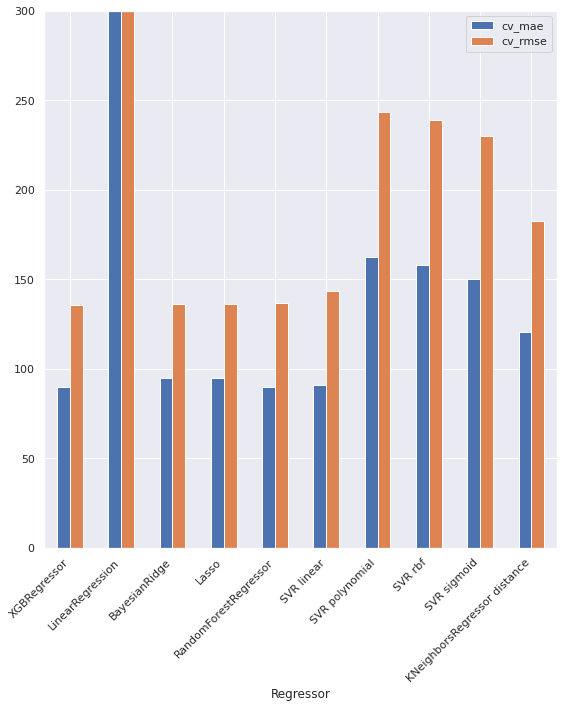

In [86]:
from matplotlib import rcParams
fig, ax = plt.subplots(1, 1, figsize = (8, 10))
ax.set(ylim=(0, 300))
rcParams.update({'figure.autolayout': True})
result_df.drop(columns=['Time, ms', 'cv_mse']).plot.bar(x='Regressor', ax=ax)
plt.xticks(rotation=45, ha="right");

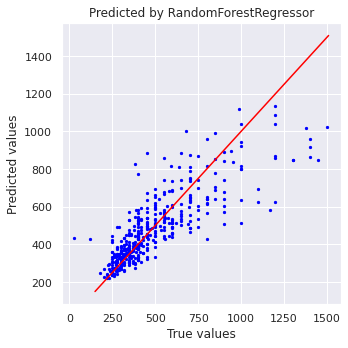

In [71]:
fig, ax = plt.subplots(1, 1, figsize = (5, 5))
max_value = max(y) + 10
plt.title('Predicted by RandomForestRegressor')
plt.scatter(y_test, predictions[4], c='blue',s=5)
plt.plot([150, max_value], [150, max_value], c='red')
plt.ylabel('Predicted values')
plt.xlabel('True values')
plt.show()

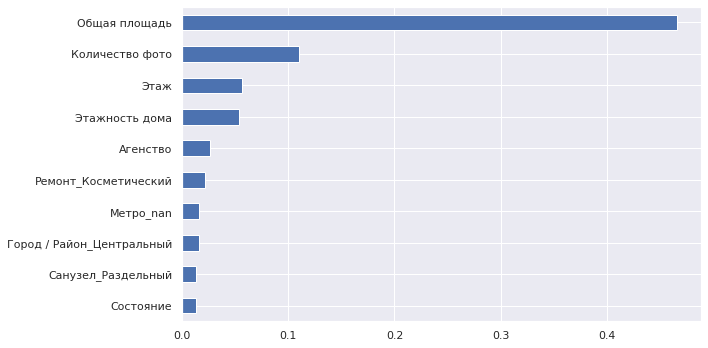

In [82]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
rfr = RandomForestRegressor()
rfr.fit(X_scaled, y)
feature_importances = pd.Series(rfr.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=True, inplace=True)
feature_importances[-10:].plot.barh()